# Anomaly Detection on Stock Price of Siemens Healthineers AG

This notebook demonstrates the process of detecting anomalies in the stock prices of Siemens Healthineers AG using an LSTM-based model.

## 1. Importing the Necessary Libraries.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Set visual styles for seaborn
sns.set(style='whitegrid')

## 2. Load Data

Here, we load the stock price data for Siemens Healthineers AG from a CSV file and visualize it to understand the price trends over time.

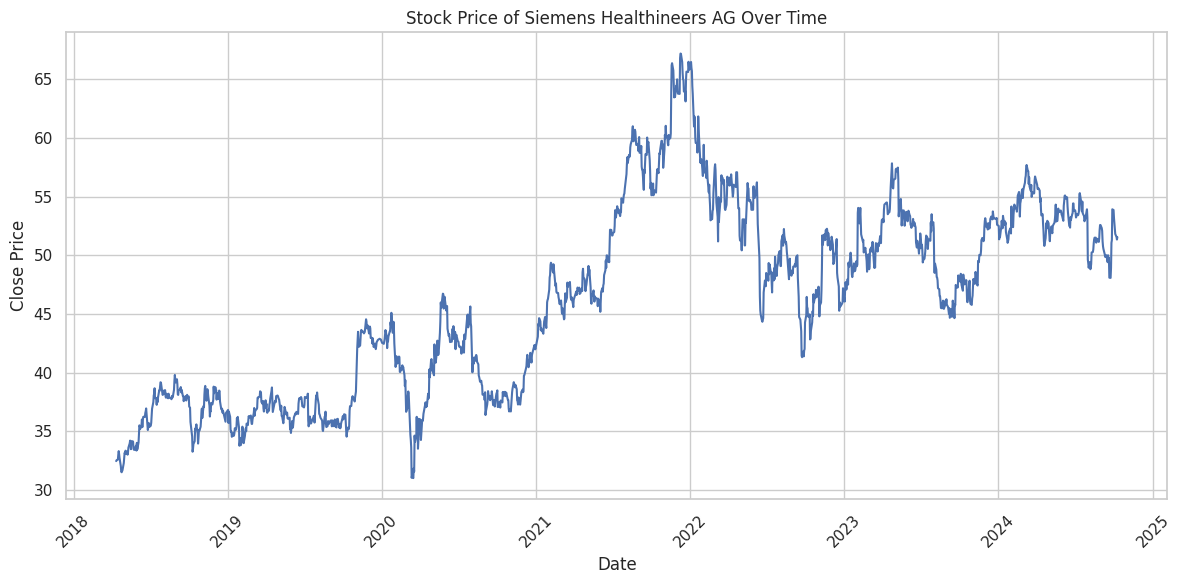

In [2]:
# Load Data
dataframe = pd.read_csv('/content/SHL_data.csv')
df = dataframe[['Date', 'Close']].copy()
df['Date'] = pd.to_datetime(df['Date'])

# Visualize the data
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['Date'], y=df['Close'])
plt.title('Stock Price of Siemens Healthineers AG Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the start and end date of the dataset
print("Start date is:", df['Date'].min())
print("End date is:", df['Date'].max())

## 3. Split Data into Train and Test Sets

In this section, we split the dataset into training and testing sets and normalize the 'Close' prices using MinMaxScaler.

In [3]:
# Split Data into Train and Test Sets
train = df.loc[df['Date'] <= '2023-04-12'].copy()
test = df.loc[df['Date'] > '2023-04-12'].copy()

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler()
train[['Close']] = scaler.fit_transform(train[['Close']])
test[['Close']] = scaler.transform(test[['Close']])

Start date is: 2018-04-12 00:00:00
End date is: 2024-10-09 00:00:00


## 4. Prepare Data for LSTM Model

We prepare the data for input into the LSTM model by creating sequences of the specified size (60 time steps).

In [4]:
# Prepare Data for LSTM Model
seq_size = 60  # Number of time steps to look back

def to_sequences(data, seq_size=1):
    x_values = []
    y_values = []
    for i in range(len(data) - seq_size):
        x_values.append(data.iloc[i:(i + seq_size)].to_numpy())
        y_values.append(data.iloc[i + seq_size].to_numpy())
    return np.array(x_values), np.array(y_values)

# Prepare the data for training and testing
trainX, trainY = to_sequences(train[['Close']], seq_size)
testX, testY = to_sequences(test[['Close']], seq_size)

## 5. Build LSTM Model

We build and compile the LSTM model using Keras. The model consists of several LSTM layers with dropout and batch normalization for regularization.

In [5]:
# Build LSTM Model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(LSTM(64, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mae')
    return model

model = build_model((trainX.shape[1], trainX.shape[2]))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 60, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 60, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 514,369 (1.96 MB)

 Trainable params: 513,601 (1.96 MB)

 Non-trainable params: 768 (3.00 KB)

## 6. Define Callbacks and Fit Model

Here, we define callbacks for early stopping, model checkpointing, and learning rate reduction. Then, we fit the model to the training data.

In [6]:
# Define Callbacks and Fit Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# Fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
                    callbacks=callbacks)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.7691 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5861 - val_loss: 0.5020 - learning_rate: 0.0010
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5139 - val_loss: 0.6150 - learning_rate: 0.0010
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4676 - val_loss: 0.4464 - learning_rate: 0.0010
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4109 - val_loss: 0.4363 - learning_rate: 0.0010
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3664 - val_loss: 0.3817 - learning_rate: 0.0010
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3265 - val_loss: 0.4414 - learning_rate: 0.0010
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2990 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2697 - val_loss: 0.4102 - learning_rate: 0.0010
Epoch 10/1

## 7. Plot Training and Validation Loss

We visualize the training and validation loss to understand how well the model is learning.

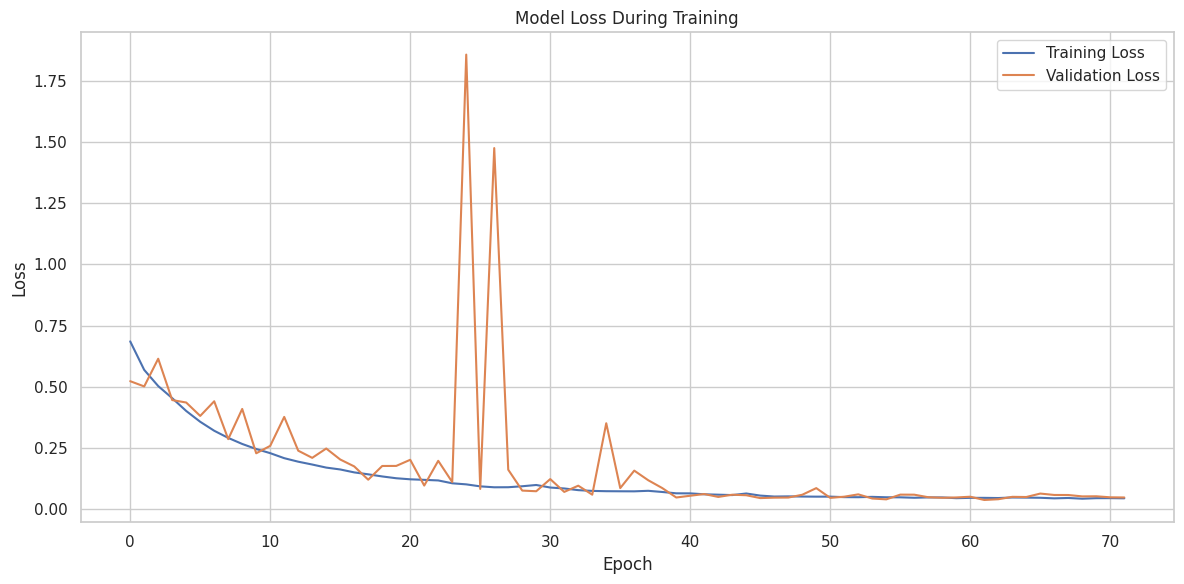

In [7]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

## 8. Predictions and Training MAE Calculation

We make predictions on the training data and calculate the Mean Absolute Error (MAE) to evaluate the model's performance.


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


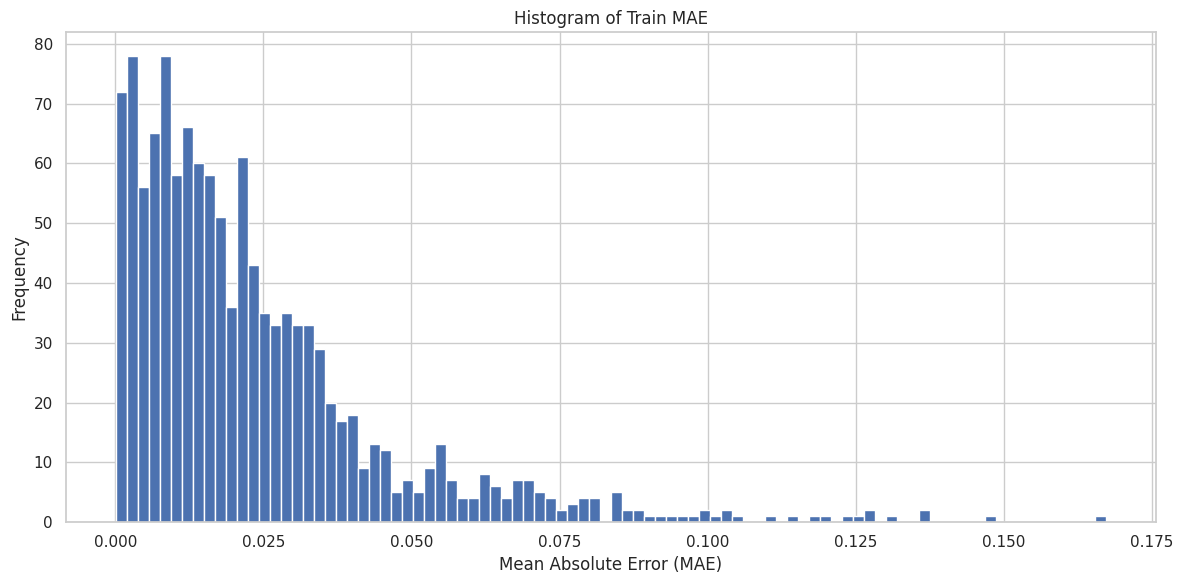

In [8]:
# Predictions and Training MAE Calculation
trainPredict = model.predict(trainX)

# Calculate MAE for training data
trainMAE = np.mean(np.abs(trainPredict - trainY.reshape(-1, 1)), axis=1)

# Plot histogram of train MAE
plt.figure(figsize=(12, 6))
plt.hist(trainMAE, bins=90)
plt.title('Histogram of Train MAE')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Calculate maximum train MAE for anomaly detection
max_trainMAE = np.percentile(trainMAE, 80)

## 9. Test Predictions and Anomaly Detection

We perform predictions on the test data and create a DataFrame to identify anomalies based on the prediction errors.

In [9]:
# Test Predictions and Anomaly Detection
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testY.reshape(-1, 1)), axis=1)

# Create DataFrame for anomalies
anomaly_df = test[seq_size:].reset_index(drop=True)
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE

# Set a threshold to mark anomalies (80th percentile)
anomaly_df['anomaly_80th'] = anomaly_df['testMAE'] > max_trainMAE

# Set a slight change threshold for anomalies
anomaly_threshold = 1e-3  # Adjust this value as needed
anomaly_df['anomaly_slight'] = anomaly_df['testMAE'] > anomaly_threshold

anomaly_df['Close'] = test[seq_size:]['Close'].reset_index(drop=True)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


## 10. Plotting Anomalies Based on 80th Percentile

We visualize the anomalies detected based on the 80th percentile of the training MAE.

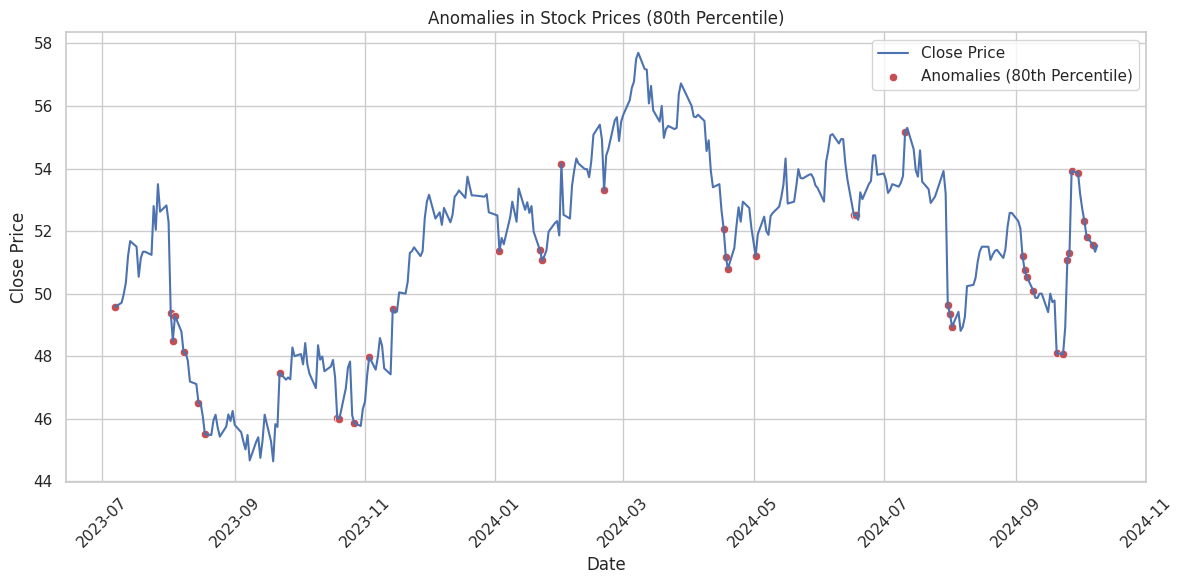

In [10]:
# Plotting Anomalies Based on 80th Percentile
plt.figure(figsize=(12, 6))
Close_2d = anomaly_df['Close'].values.reshape(-1, 1)

# Plot the close price
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(Close_2d)[:, 0], label='Close Price')

# Scatter plot for 80th percentile anomalies
anomalies_80th = anomaly_df[anomaly_df['anomaly_80th'] == True]
sns.scatterplot(x=anomalies_80th['Date'], y=scaler.inverse_transform(anomalies_80th['Close'].values.reshape(-1, 1))[:, 0], color='r', label='Anomalies (80th Percentile)')

plt.title('Anomalies in Stock Prices (80th Percentile)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save the plot
plt.savefig('/content/anomaly_80th_percentile.png')
plt.show()

## 11. Plotting Anomalies Based on Slight Change

Finally, we visualize anomalies detected based on a slight change threshold.

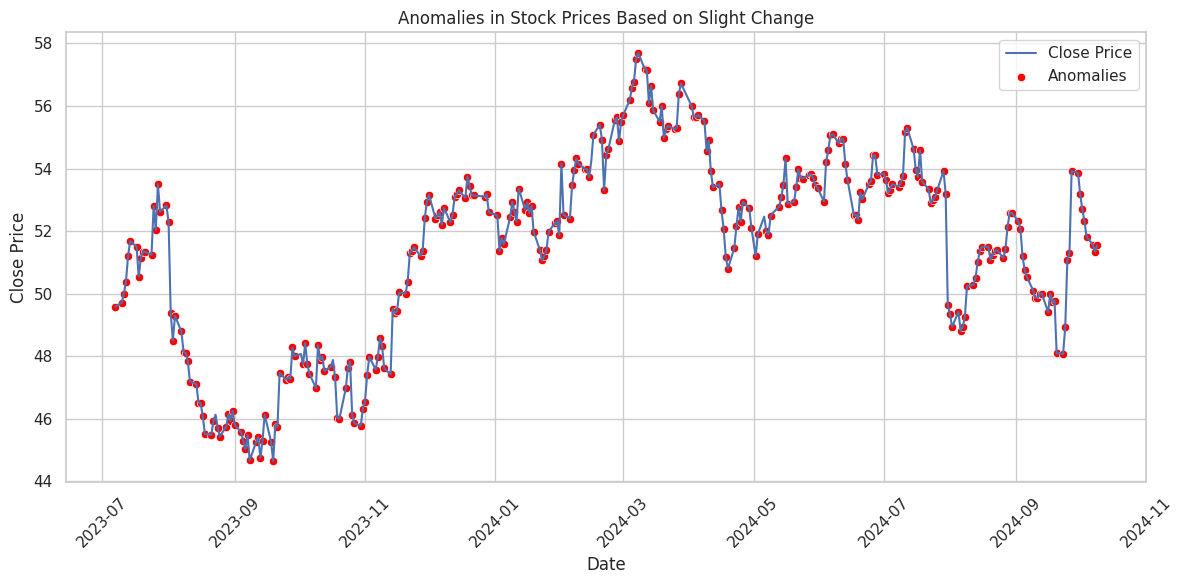

In [11]:
# Plotting Anomalies Based on Slight Change
plt.figure(figsize=(12, 6))
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(Close_2d)[:, 0], label='Close Price')

# Scatter plot for slight change anomalies
anomalies_slight = anomaly_df[anomaly_df['anomaly_slight'] == True]
sns.scatterplot(x=anomalies_slight['Date'],
                y=scaler.inverse_transform(anomalies_slight['Close'].values.reshape(-1, 1))[:, 0],
                color='red', label='Anomalies')

# Adding labels and title
plt.title('Anomalies in Stock Prices Based on Slight Change')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save the plot
plt.savefig('/content/anomaly_slight_change.png')
plt.show()